In [5]:
%matplotlib inline  


In [59]:
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import torch
from torch import nn
from torch import optim
from IPython import display
from matplotlib.pyplot import *

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.campus_env import CampusEnv
from lib import plotting

matplotlib.style.use('ggplot')



class Estimator():
    #Initialize the model
    def __init__(self):
        inputLayerSize, hiddenLayerSize, outputLayerSize = 9, 20, 1
        self.lr = 1e-3;
        self.criterion = nn.MSELoss()
        self.losses = []  #for visulization purpose
        self.models = []
        self.optimizers = []
        for i in range(8):
            model = nn.Sequential(nn.Linear(inputLayerSize, hiddenLayerSize),
                                  nn.Sigmoid(),
                       nn.Linear(hiddenLayerSize, outputLayerSize) 
                       )
            self.models.append(model)
            opt = optim.SGD(self.models[i].parameters(), lr=self.lr)
            self.optimizers.append(opt)
            
    #Return prediction on the state    
    def predict(self,s,a = None):
        s = torch.from_numpy(s).float()
        if not a:
            return np.array([m(s).detach().numpy()for m in self.models]).flatten()
        else:
            return self.models[a](s).detach().numpy()
       
    def update(self, s, a, y, i_episode):
        s = torch.from_numpy(s).float()
        yhat = self.models[a](s)
        #print(s)
        #print(yhat, "Q-s-a-estimated")
        y = torch.from_numpy(np.array(y)).view(1).float()
        #print(y, "TD Target")
        loss = self.criterion(y, yhat)
        #print(loss, "loss")
        loss.backward()
        self.optimizers[a].step() 
        self.optimizers[a].zero_grad()
        self.losses.append(loss.item())
        #if i_episode%25==0:
           # clf(); fig = figure(0, (18, 9))
           # plot(self.losses, linewidth = 2)
           # xlabel('Iterations'); ylabel('losses')
            #display.clear_output(wait=True); display.display(gcf())
        


def make_epsilon_greedy_policy(estimator, epsilon, nA, i_episode):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        #print(q_values, "q_values")
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

def q_learning(env, estimator, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    #Q = defaultdict(lambda: np.zeros(8))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    rewards_cumulative = []
    
    state = env.reset()
    for i in range(8):
        estimator.update(state,i, [0], -1)
    
    for i_episode in range(num_episodes):
        #print(i_episode, "episode")
        # The policy we're following
        policy = make_epsilon_greedy_policy(estimator, epsilon * epsilon_decay**i_episode, 8,i_episode)
        # Print out which episode we're on, useful for debugging.
        #if (i_episode + 1) % 100 == 0:
         #   print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
         #   sys.stdout.flush()
         
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        

        # Implement this!
        # Reset the environment and pick the first action
        #YOU HAVE TO REWRITE THIS, OTHERWISE IT WILL GET RID OF ALL STUDENTS
        state = env.reset()
        
        next_action = None
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            if next_action is None:
                action_probs = policy(state)
                #print(action_probs, "action probability")
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
           
            
            #Next state after stepping
            next_state, reward, done, _ = env.step(action)
            #print(reward, "reward after taking best action")
            #print(action, "action is")
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            #print(stats.episode_rewards[i_episode], "cumulative reward")
            
            # TD Update
            #best_next_action = np.argmax(Q[next_state])    
            #td_target = reward + discount_factor * Q[next_state][best_next_action]
            #td_delta = td_target - Q[state][action]
            #Q[state][action] += alpha * td_delta
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            #print(q_values_next, "q_value_next")
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Update the function approximator using our target
            estimator.update(state,action, td_target, i_episode)
            
            print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
            
        #Plotting rewards while training
        rewards_cumulative.append(stats.episode_rewards[i_episode])
        if i_episode%1==0:
            clf(); fig = figure(0, (18, 9))
            plot(rewards_cumulative, linewidth = 2)
            xlabel('Episodes'); ylabel('reward')
            display.clear_output(wait=True); display.display(gcf())
        
    return stats


In [60]:
env = CampusEnv()

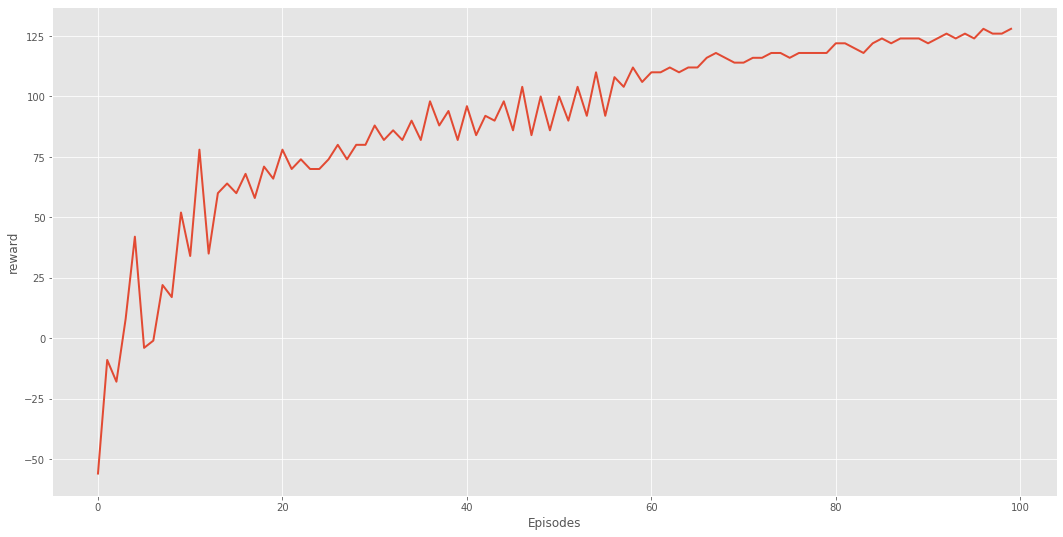

<Figure size 432x288 with 0 Axes>

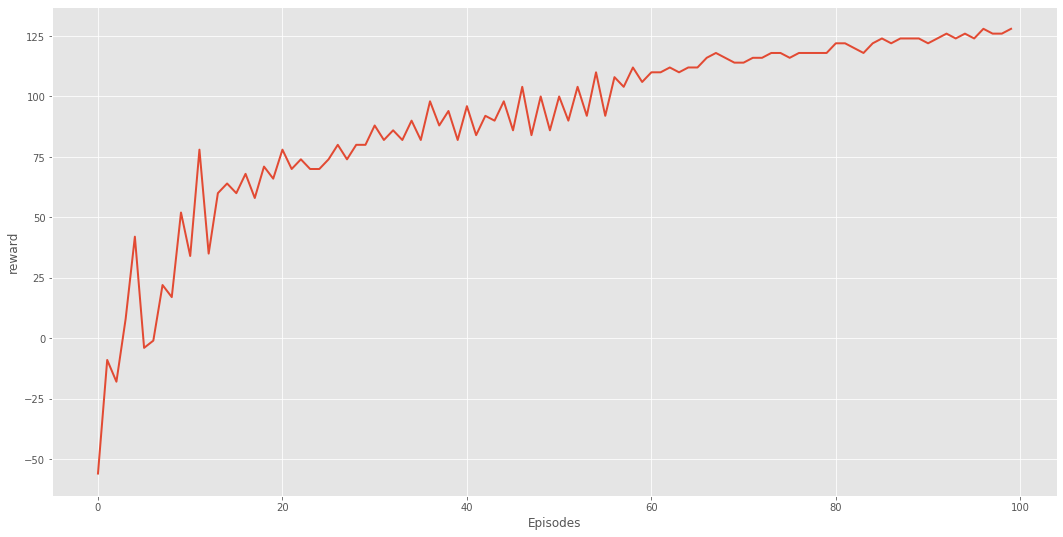

In [61]:

estimator = Estimator()
stats = q_learning(env, estimator, 100, epsilon=0.0)

#plotting.plot_episode_stats(stats, smoothing_window=25)
#print(stats.episode_rewards, "stats episode rewards")

In [63]:
estimator.predict(np.array([3,0,0,5,9,0,0,0,4]))

array([29.229574  , 27.070997  , 25.500956  , 47.86012   , 38.91386   ,
       47.846554  , -0.21876658, -0.22529802], dtype=float32)